In [14]:
# Imports
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import xml.etree.ElementTree as ET
import zipfile
import io
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet

In [15]:
# Base URL for Citibike S3 bucket
index_url = 'https://s3.amazonaws.com/tripdata/'
response = requests.get(index_url)
root = ET.fromstring(response.content)

# Parse the S3 XML to get all .csv.zip file names
namespace = {'s3': 'http://s3.amazonaws.com/doc/2006-03-01/'}
zip_files = [
    elem.find('s3:Key', namespace).text
    for elem in root.findall('s3:Contents', namespace)
    if elem.find('s3:Key', namespace).text.endswith('.zip')
]

# print(f"Total ZIP files found: {len(zip_files)}")

# Split the files into 3 batches
# batch1_files = [f for f in zip_files if f.startswith(tuple(str(y) for y in range(2013, 2024)))]
batch2_files = [f for f in zip_files if f.startswith(tuple(f"{y}{m:02d}" for y in range(2024, 2026) for m in range(1, 13)))]
# batch3_files = [f for f in zip_files if f.startswith('JC-')]

In [17]:
files_2024_2025 = []
for filename in batch2_files:
    if filename.startswith('2024') or filename.startswith('2025'):
        files_2024_2025.append(filename)

In [18]:
# This code chunk was generated by Google Gemini for memory efficient data
# processing. This code downloads and processes zipped CSV files for
# 2024 and 2025 Citi Bike data in memory-efficient chunks and selects only
# essential columns. It then combines these chunks into a single DataFrame for
# further analysis and visualization. This allows for more memory efficient
# processing to avoid going over the free-tier Google Colab RAM limit.

all_chunks = []
chunk_size = 50000 # Adjusted chunk size for potentially larger 2024/2025 files
daily_rides_list = [] # List to store daily ride counts from each file

for filename in files_2024_2025:
    file_url = f"{index_url}{filename}"

    try:
        response = requests.get(file_url)
        response.raise_for_status()

        with zipfile.ZipFile(io.BytesIO(response.content)) as zf:
            csv_files = [f for f in zf.namelist() if f.endswith('.csv')]

            if not csv_files:
                print(f"No CSV file found in {filename}. Skipping.")
                continue

            csv_filename = csv_files[0]

            with zf.open(csv_filename) as csvfile:
                csv_content = io.StringIO(csvfile.read().decode('utf-8'))
                chunk_iterator = pd.read_csv(csv_content, chunksize=chunk_size)

                for chunk in chunk_iterator:
                    # Convert 'started_at' to datetime and set as index for the chunk
                    chunk['started_at'] = pd.to_datetime(chunk['started_at'])
                    chunk.set_index('started_at', inplace=True)

                    # Resample the chunk to daily frequency and count rides
                    daily_rides_chunk = chunk.resample('D').size().to_frame(name='ride_count')
                    daily_rides_list.append(daily_rides_chunk)



    except requests.exceptions.RequestException as e:
        print(f"Error downloading {filename}: {e}")
    except zipfile.BadZipFile:
        print(f"Error processing {filename}: Not a valid zip file.")
    except Exception as e:
        print(f"An unexpected error occurred while processing {filename}): {e}")

# Concatenate all daily ride count chunks into a single DataFrame
if daily_rides_list:
    daily_rides = pd.concat(daily_rides_list).groupby(level=0).sum()
    # Sort the index before setting frequency
    daily_rides.sort_index(inplace=True)

    # Reindex to a full daily range and fill missing values with 0
    full_date_range = pd.date_range(start=daily_rides.index.min(), end=daily_rides.index.max(), freq='D')
    daily_rides = daily_rides.reindex(full_date_range, fill_value=0)

    # Set the frequency of the index (should work now after reindexing)
    daily_rides.index.freq = 'D'

    #print("\nDaily rides data head:")
    #display(daily_rides.head())
    print("\nDaily rides data info:")
    daily_rides.info()
else:
    print("No data loaded.")


Daily rides data info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 518 entries, 2024-01-14 to 2025-06-14
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   ride_count  518 non-null    int64
dtypes: int64(1)
memory usage: 8.1 KB


In [19]:
# Remove rows with NaN values in 'ride_count'
daily_rides = daily_rides.dropna(subset=['ride_count'])

# Remove rows where 'ride_count' is zero
daily_rides = daily_rides[daily_rides['ride_count'] > 0]

daily_rides.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 341 entries, 2024-01-14 to 2025-06-14
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   ride_count  341 non-null    int64
dtypes: int64(1)
memory usage: 5.3 KB


In [20]:
# Split data into training and testing sets
train_size = int(len(daily_rides) * 0.8)
train_data = daily_rides[:train_size]
test_data = daily_rides[train_size:]

print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

Training data shape: (272, 1)
Testing data shape: (69, 1)


In [24]:
# SARIMA MODEL
# Fit SARIMA model using statsmodels
# Standard starting values for order (5,1,0) and seasonal_order (1,1,1,7)
# with weekly seasonality (s=7)
order = (5, 1, 0)
seasonal_order = (1, 1, 1, 7)

statsmodels_sarima_model = ARIMA(train_data['ride_count'], order=order, seasonal_order=seasonal_order)
statsmodels_sarima_results = statsmodels_sarima_model.fit()

# Print model summary
print(statsmodels_sarima_results.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                        ride_count   No. Observations:                  272
Model:             ARIMA(5, 1, 0)x(1, 1, [1], 7)   Log Likelihood               -2965.437
Date:                           Sun, 03 Aug 2025   AIC                           5946.874
Time:                                   23:11:28   BIC                           5975.482
Sample:                                        0   HQIC                          5958.370
                                           - 272                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2181      0.098     -2.216      0.027      -0.411      -0.025
ar.L2         -0.0879      0.122     -0.722

In [26]:
# Generate forecast for the next 6 months (approx 180 days)
forecast_steps = 180
sarima_forecast_future = statsmodels_sarima_results.forecast(steps=forecast_steps)

# Create date index for the forecast starting from the day after the last date
# in daily_rides
last_date = daily_rides.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Create pandas Series for forecast with correct date index
sarima_forecast_future.index = forecast_index

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


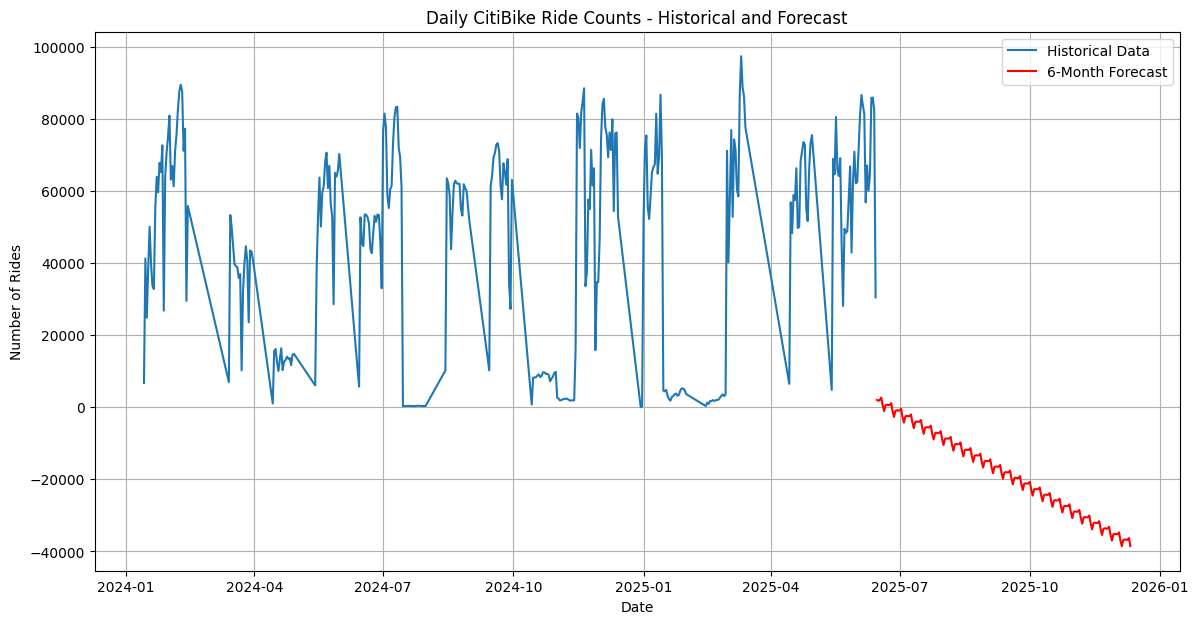

In [27]:
# SARIMA Visualization (Not included in Capstone)
# Visualize historical data and forecast
plt.figure(figsize=(14, 7))
plt.plot(daily_rides['ride_count'], label='Historical Data')
plt.plot(sarima_forecast_future, label='6-Month Forecast', color='red')
plt.title('Daily CitiBike Ride Counts - Historical and Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# PROPHET MODEL
# Prepare data for Prophet
prophet_data = daily_rides.reset_index()
prophet_data.rename(columns={'index': 'ds', 'ride_count': 'y'}, inplace=True)

In [29]:
# Initialize Prophet model
prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True, seasonality_prior_scale=0.5)

# Fit the model to the prepared data
prophet_model.fit(prophet_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0cmy1m34/s87ilpdu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0cmy1m34/8zv7r6tx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73727', 'data', 'file=/tmp/tmp0cmy1m34/s87ilpdu.json', 'init=/tmp/tmp0cmy1m34/8zv7r6tx.json', 'output', 'file=/tmp/tmp0cmy1m34/prophet_modelaishw01k/prophet_model-20250803231155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:11:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:11:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [30]:
# Create a DataFrame with future dates for forecasting
future_periods = 180 # Forecast for the next 6 months (approx 180 days)
future_prophet_data = prophet_model.make_future_dataframe(periods=future_periods)

# Generate forecasts
prophet_forecast = prophet_model.predict(future_prophet_data)

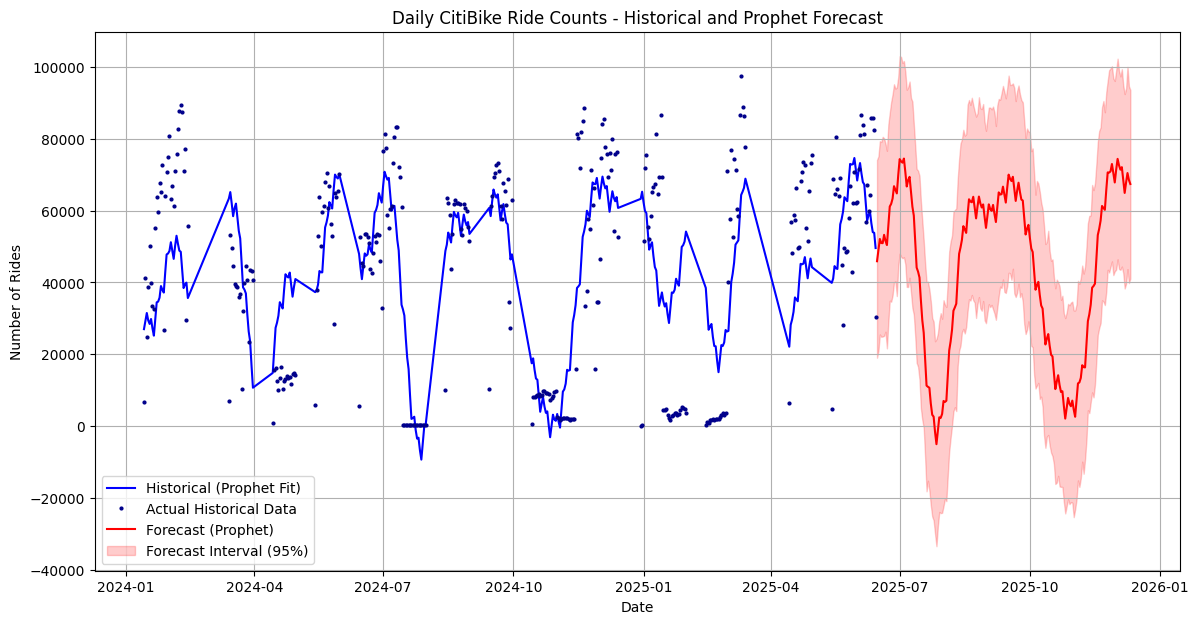

In [31]:
# Visualize Prophet Forecast
# Separate historical and forecasted data for plotting
historical_data_plot = prophet_forecast.iloc[:len(daily_rides)]
forecast_data_plot = prophet_forecast.iloc[len(daily_rides):]

# Plotting
plt.figure(figsize=(14, 7))

# Plot historical data
plt.plot(historical_data_plot['ds'], historical_data_plot['yhat'], label='Historical (Prophet Fit)', color='blue')

# Overlay actual historical data points for comparison
plt.plot(daily_rides.index, daily_rides['ride_count'], 'o', markersize=2, color='darkblue', label='Actual Historical Data')

# Plot forecasted data
plt.plot(forecast_data_plot['ds'], forecast_data_plot['yhat'], label='Forecast (Prophet)', color='red')

# Add prediction intervals
plt.fill_between(forecast_data_plot['ds'],
                 forecast_data_plot['yhat_lower'],
                 forecast_data_plot['yhat_upper'], color='red', alpha=0.2, label='Forecast Interval (95%)')

plt.title('Daily CitiBike Ride Counts - Historical and Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# Calculate metrics for Statsmodels SARIMA model on test set
# Generate predictions for the test set period using integer indexing relative to the training data
sarima_test_forecast = statsmodels_sarima_results.predict(start=len(train_data), end=len(daily_rides)-1)

# Set and align test_data and sarima_test_forecast to have the same index
sarima_test_forecast.index = test_data.index
sarima_test_data_aligned = test_data.loc[sarima_test_forecast.index]

# SARIMA mse, mae, rmse
sarima_mse_statsmodels = mean_squared_error(sarima_test_data_aligned['ride_count'], sarima_test_forecast)
sarima_mae_statsmodels = mean_absolute_error(sarima_test_data_aligned['ride_count'], sarima_test_forecast)
sarima_rmse_statsmodels = np.sqrt(sarima_mse_statsmodels)

# Calculate metrics for Prophet model on test set
# Create a future dataframe for the test period only
future_prophet_test = pd.DataFrame({'ds': test_data.index})

# Generate forecasts for the test period
prophet_test_forecast_df = prophet_model.predict(future_prophet_test)
prophet_test_forecast = prophet_test_forecast_df.set_index('ds')['yhat'] # set and align index
prophet_test_data_aligned = test_data.loc[prophet_test_forecast.index]

# Prophet mse, mae, rmse
prophet_mse = mean_squared_error(prophet_test_data_aligned['ride_count'], prophet_test_forecast)
prophet_mae = mean_absolute_error(prophet_test_data_aligned['ride_count'], prophet_test_forecast)
prophet_rmse = np.sqrt(prophet_mse)

Metrics calculated.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [38]:
# Ensure the metric variables are available from previous calculations
# prophet_mse, prophet_mae, prophet_rmse
# sarima_mse_statsmodels, sarima_mae_statsmodels, sarima_rmse_statsmodels

print("--- Model Performance Metrics Comparison (on Test Set) ---")
print("\nProphet Model:")
print(f"  Mean Squared Error (MSE): {prophet_mse:.2f}")
print(f"  Mean Absolute Error (MAE): {prophet_mae:.2f}")
print(f"  Root Mean Squared Error (RMSE): {prophet_rmse:.2f}")

print("\nStatsmodels SARIMA Model:")
print(f"  Mean Squared Error (MSE): {sarima_mse_statsmodels:.2f}")
print(f"  Mean Absolute Error (MAE): {sarima_mae_statsmodels:.2f}")
print(f"  Root Mean Squared Error (RMSE): {sarima_rmse_statsmodels:.2f}")

--- Model Performance Metrics Comparison (on Test Set) ---

Prophet Model:
  Mean Squared Error (MSE): 451723303.82
  Mean Absolute Error (MAE): 18926.09
  Root Mean Squared Error (RMSE): 21253.78

Statsmodels SARIMA Model:
  Mean Squared Error (MSE): 4744915177.89
  Mean Absolute Error (MAE): 63832.34
  Root Mean Squared Error (RMSE): 68883.34
